# Inter/intra observer variations: figure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tiff
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import cm
import matplotlib.font_manager as font_manager
import os

from utils import get_info_from_report

In this notebook, we will create figures that highlight the calculated beam target coordinates in a proton radiographic image based on the transformation parameters from different users. This shows how much the target precision is influenced by inter-obser-variations. Let's first load the data:

In [5]:
root = r'C:\Users\johamuel\Documents\BiAPoL\Shared\BiAPoLprojects\64_radiographic_workflow\Registration_user_study'
#root = r'E:\BiAPoL\Shared\BiAPoLprojects\64_radiographic_workflow\Registration_user_study'
#root = r'C:\Users\schnei17\Documents\PhD\Paper\Protonenradiografie\planning_study\Registration_user_study'

We also have to load some of the original imaging data for each of the mice.

In [16]:
imaging_dir = r'C:\Users\johamuel\Documents\BiAPoL\Shared\BiAPoLprojects\64_radiographic_workflow\Data_Registration'
#imaging_dir = r'C:\Users\schnei17\Documents\PhD\Paper\Protonenradiografie\planning_study\Data_Registration'

## Config

In [6]:
anonymize = True
save_figures = True

In [7]:
animals = os.listdir(root)

### Normalization

For better comparison acros mice, it is desirable to normalize the registration parameters by subtracting the mean of the respective vaue and animal. I.e., the motor destination coordinates of animal $X$ are calculated as 

$\text{Motor_destination}_X = \text{Motor_destination}_X - mean(\text{Motor_destination}_X)$

In [8]:
colums_to_normalize = ['isocenter_coords_x', 'isocenter_coords_y', 'target_coords_xr_x', 'target_coords_xr_y', 'target_coords_rg_x',
                       'target_coords_rg_y', 'motor_origin_x', 'motor_origin_y', 'motor_dest_x', 'motor_dest_y', 'trafo_angle', 'trafo_x', 'trafo_y']

Now, we collect all the data from the acquired log files. We put the results of all registration studies for a particular animal into a dictionary and stack these later-on.

In [10]:
results = []
for animal in animals:
    _results = []
    for study in os.listdir(os.path.join(root, animal)):
        observer = study.split('_')[1]
        
        
        report_file = os.path.join(root, animal, study, 'report.txt')
        info = get_info_from_report(report_file)
        
        data_columns = list(info.keys())

        info['observer'] = observer
        info['animal'] = animal
        
        _results.append(info)
    _df = pd.DataFrame(_results)
    results.append(_df)
df = pd.concat(results)

## Inter-observer variability

We first analyze inter-observer variability. For this, we remove occurrences of repeated registration of animals by single users. More precisely, if an observer repeated the registration of the ame animal multiple times, we keep only the results of the first registration.

In [11]:
inter_observer = df.drop_duplicates(subset = ['observer', 'animal'], keep='first').reset_index(drop=True)

# Normalize selected columns
for animal in animals:
    sub_df = inter_observer[inter_observer['animal'] == animal]
    inter_observer.loc[sub_df.index, colums_to_normalize] = sub_df[colums_to_normalize] - sub_df[colums_to_normalize].mean()
    
if anonymize:
    inter_observer['observer'] = 'Observer ' + pd.Series(pd.factorize(inter_observer['observer'])[0] + 1).astype(str)

#inter_observer

### Display target coordinates inter variability in radiographic image

calculate best/worst variability of target coordinates in radiography

In [12]:
dist = np.sqrt(inter_observer['target_coords_rg_x']**2 + inter_observer['target_coords_rg_y']**2)
dist_reshape = np.reshape(np.array(dist), (10, 3))
dist_mean = np.mean(dist_reshape, axis=1) 

max_dist = np.max(dist_mean)
max_dist_std = np.std(dist_reshape[np.argmax(dist_mean)])
max_mouse = animals[np.argmax(dist_mean)]
print(f'maximum distance variability: {max_dist} +/- {max_dist_std} mm for mouse {max_mouse}')

min_dist = np.min(dist_mean)
min_dist_std = np.std(dist_reshape[np.argmin(dist_mean)])
min_mouse = animals[np.argmin(dist_mean)]
print(f'minimum distance variability: {min_dist} +/- {min_dist_std} mm for mouse {min_mouse}')

global_mean = np.mean(dist_mean)
global_mean_std = np.std(dist_mean)
print(f'global mean distance variability: {global_mean} +/- {global_mean_std} mm')

maximum distance variability: 0.40638646431503705 +/- 0.18668165850324786 mm for mouse P2E_M11
minimum distance variability: 0.11633644718980846 +/- 0.050763590952217344 mm for mouse P1_H_B6_M52
global mean distance variability: 0.2714415303614972 +/- 0.10341595293440795 mm


We need to load the imaging data for these two animals to create a figure for them:

In [18]:
rg_max_mouse = tiff.imread(os.path.join(imaging_dir, 'P2E_M14', 'Maus14.tif'))
rg_min_mouse = tiff.imread(os.path.join(imaging_dir, 'P1_H_C3H_M54', '20220405090035_MS54_35x20y.tif'))

inter_observer = df.drop_duplicates(subset = ['observer', 'animal'], keep='first').reset_index(drop=True)
for animal in animals:
    sub_df = inter_observer[inter_observer['animal'] == animal]
    inter_observer.loc[sub_df.index, colums_to_normalize] = sub_df[colums_to_normalize]

x_rg_max = np.array(inter_observer['target_coords_rg_x'][8*3:8*3+3])
y_rg_max = np.array(inter_observer['target_coords_rg_y'][8*3:8*3+3])
x_rg_min = np.array(inter_observer['target_coords_rg_x'][5*3:5*3+3])
y_rg_min = np.array(inter_observer['target_coords_rg_y'][5*3:5*3+3])

sns.set_style("white")


idxes = [1,2,3]
cmap = plt.cm.get_cmap('viridis')
color=[cmap(0.9999999), cmap(0.5), cmap(0)]
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='normal',
                                   style='normal', size=20)
font_1 = font_manager.FontProperties(family='Times New Roman',
                                   weight='normal',
                                   style='normal', size=40)

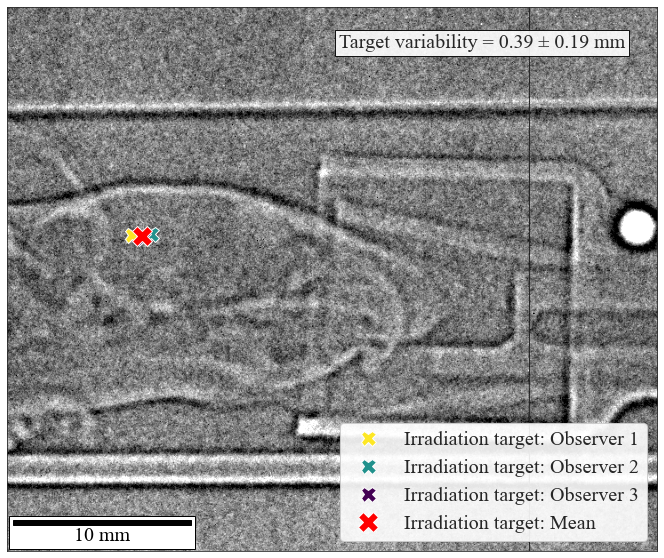

In [19]:
# max variability mouse radiography
fig, ax = plt.subplots(figsize = (15, 10))
ax.imshow(rg_max_mouse[400:,300:], origin='upper', cmap='gray_r', vmin=142, vmax=165)
#ax.set_title(f'Mouse {max_mouse} with highest variability')
for idx, x, y in zip(idxes, x_rg_max, y_rg_max):
    ax.plot(x/0.05-300, rg_max_mouse.shape[0]-y/0.05-400, marker='X', ms = 15, 
                  label=f'Irradiation target: Observer {idx}', linewidth=0, color=color[idx-1], markeredgecolor='white')
ax.plot(np.mean(x_rg_max/0.05-300), np.mean(rg_max_mouse.shape[0]-y_rg_max/0.05-400), marker='X', ms = 20, 
              label=f'Irradiation target: Mean', color='red', linewidth=0, markeredgecolor='white')
ax.legend(fontsize=14, loc = 'lower right', prop=font, framealpha=0.9)
ax.add_artist(AnchoredSizeBar(ax.transData, 200, '10 mm', 'lower left', 
                                  pad=0.2, color='black', frameon=True,
                                  size_vertical=5, fontproperties=font))
ax.text(0.95, 0.95, 'Target variability = {:.2f} \u00B1 {:.2f} mm'.format(dist_mean[8], np.std(dist_reshape[8])), transform=ax.transAxes, 
             horizontalalignment='right', verticalalignment='top', fontsize=14, 
             bbox={'facecolor': 'white', 'edgecolor': 'black', 'alpha': 0.9}, font=font)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ax.figure.savefig(f'./figures/Target_variability_{max_mouse}')

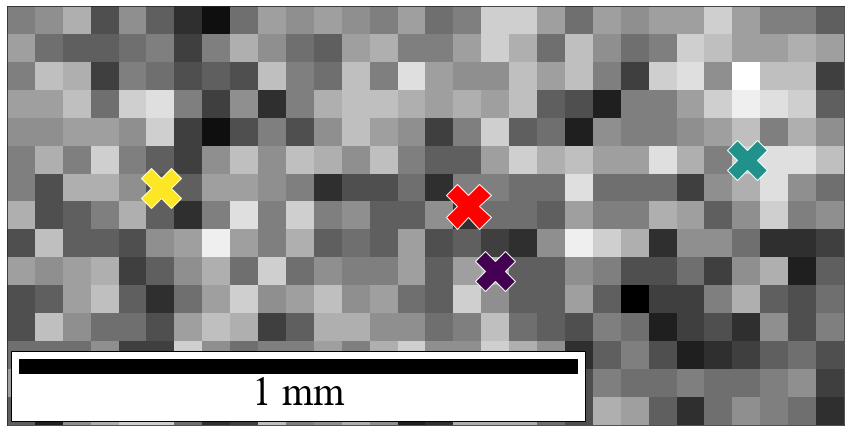

In [20]:
# ZOOM max variability mouse radiography 
fig, ax = plt.subplots(figsize = (15, 10))
ax.imshow(rg_max_mouse[650:665,435:465], origin='upper', cmap='gray_r')
#ax.set_title(f'Mouse {max_mouse} with highest variability')
for idx, x, y in zip(idxes, x_rg_max, y_rg_max):
    ax.plot(x/0.05-435, rg_max_mouse.shape[0]-y/0.05-650, marker='X', ms = 40, linewidth=0, color=color[idx-1], 
            markeredgecolor='white')
ax.plot(np.mean(x_rg_max/0.05-435), np.mean(rg_min_mouse.shape[0]-y_rg_max/0.05-650), marker='X', ms = 45, color='red', 
              linewidth=0, markeredgecolor='white')
ax.add_artist(AnchoredSizeBar(ax.transData, 20, '1 mm', 'lower left', 
                                  pad=0.2, color='black', frameon=True,
                                  size_vertical=0.5, fontproperties=font_1))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ax.figure.savefig(f'./figures/Target_variability_{max_mouse}_ZOOM')

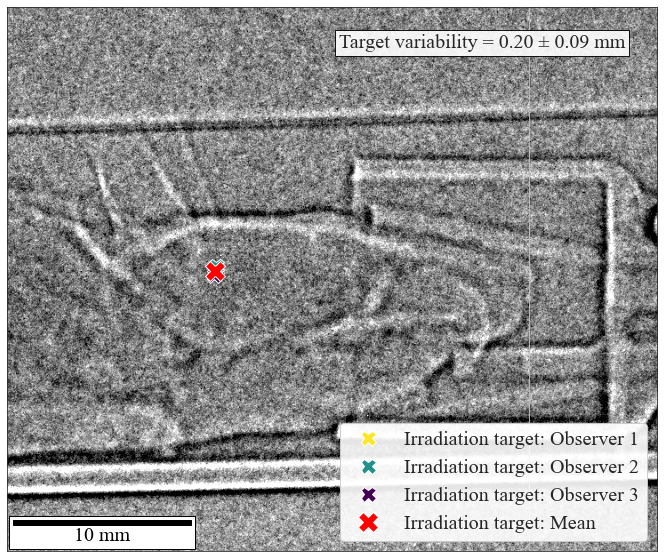

In [21]:
# min variability mouse radiography
fig, ax = plt.subplots(figsize = (15, 10))
ax.imshow(rg_min_mouse[400:,300:], origin='upper', cmap='gray_r', vmin=32, vmax=50)
#ax.set_title(f'Mouse {min_mouse} with lowest variability')
for idx, x, y in zip(idxes, x_rg_min, y_rg_min):
    ax.plot(x/0.05-300, rg_min_mouse.shape[0]-y/0.05-400, marker='X', ms = 15, 
                  label=f'Irradiation target: Observer {idx}', linewidth=0, color=color[idx-1], markeredgecolor='white')
ax.plot(np.mean(x_rg_min/0.05-300), np.mean(rg_min_mouse.shape[0]-y_rg_min/0.05-400), marker='X', ms = 20, 
              label=f'Irradiation target: Mean', color='red', linewidth=0, markeredgecolor='white')
ax.legend(fontsize=14, loc = 'lower right', prop=font, framealpha=0.9)
ax.add_artist(AnchoredSizeBar(ax.transData, 200, '10 mm', 'lower left', 
                                  pad=0.2, color='black', frameon=True,
                                  size_vertical=5, fontproperties=font))
ax.text(0.95, 0.95, 'Target variability = {:.2f} \u00B1 {:.2f} mm'.format(dist_mean[5], np.std(dist_reshape[5])), transform=ax.transAxes, 
             horizontalalignment='right', verticalalignment='top', fontsize=14, 
             bbox={'facecolor': 'white', 'edgecolor': 'black', 'alpha': 0.9}, font=font)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ax.figure.savefig(f'./figures/Target_variability_{min_mouse}')

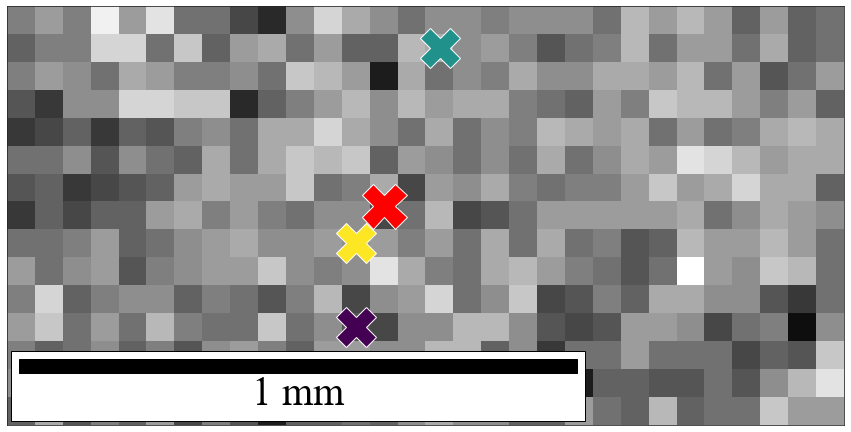

In [22]:
# ZOOM min variability mouse radiography 
fig, ax = plt.subplots(figsize = (15, 10))
ax.imshow(rg_min_mouse[690:705,520:550], origin='upper', cmap='gray_r')
#ax.set_title(f'Mouse {min_mouse} with lowest variability')
for idx, x, y in zip(idxes, x_rg_min, y_rg_min):
    ax.plot(x/0.05-520, rg_min_mouse.shape[0]-y/0.05-690, marker='X', ms = 40, linewidth=0, color=color[idx-1], 
            markeredgecolor='white')
ax.plot(np.mean(x_rg_min/0.05-520), np.mean(rg_min_mouse.shape[0]-y_rg_min/0.05-690), marker='X', ms = 45, color='red', 
        linewidth=0, markeredgecolor='white')
ax.add_artist(AnchoredSizeBar(ax.transData, 20, '1 mm', 'lower left', pad=0.2, color='black', frameon=True,
                              size_vertical=0.5, fontproperties=font_1))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ax.figure.savefig(f'./figures/Target_variability_{min_mouse}_ZOOM')